# Motivation

The goal of this assignment is to:
1. Calculate a midmarket implied volatility for each strike based on a discrete set of option prices across different strikes at a single maturity.
2. Calibrate a set of SVI parameters that fit this volatility slice.
3. Compute a midmarket price for the 20 Dec 2019 2707.88 (at-the-money) call.
4. Use your SVI volatility curve to price the 20 December 2019 variance swap


In [2]:
import numpy as np
from numpy import matrix
import pandas as pd
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import matplotlib.pyplot as plt 
import pandas_datareader.data as web
from pandas import DataFrame
from sklearn.linear_model import LinearRegression

In [3]:
#The Spot as well as time variables are bbserved from the data file
S0 = 2707.88
t0 = '02-08-2019'
expiry = '12-20-2019'
t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.strptime(t0, "%m-%d-%Y")).days / 365


In [4]:
#Loading the data 
import pandas as pd

df = pd.read_table('quotedata.dat',
                  skiprows=2,
                  sep=',',
                  header=0)

In [5]:
#Lets take a look at the df make sure data makes sense
df.head()

,Expiration Date,Calls,CBid,CAsk,Strike,Puts,PBid,PAsk
0,12/20/2019,SPX191220C01750000,955.0,958.7,1750.0,SPX191220P01750000,8.9,9.5
1,12/20/2019,SPX191220C01775000,931.4,935.1,1775.0,SPX191220P01775000,9.7,10.3
2,12/20/2019,SPX191220C01800000,907.9,911.5,1800.0,SPX191220P01800000,10.6,11.2
3,12/20/2019,SPX191220C01825000,884.5,888.1,1825.0,SPX191220P01825000,11.5,12.2
4,12/20/2019,SPX191220C01850000,861.1,864.7,1850.0,SPX191220P01850000,12.5,13.2


### Estimating Market implied r and q
though r is provided in the description of the problem, it can also be estimated using Put Call Parity and the forward equation: (Curtesy of Matt Davis)
$$ C(S, K, T) - P(S, K, T) = e^{-rT} (F-K)$$

where $$ F = S e^{(r-q)T}$$

rearranging the two equations above

$$ [C(S, K, T) - P(S, K, T)] e^{rT} =  (F-K)$$

$$ [C(S, K, T) - P(S, K, T)] e^{rT} + K =  F $$

if we regress C-P vs. strikes The put - call parity and F being constant accross strikes yields the slope m to:


$$ m = e^{rT} $$

which simplifies to $$r = \frac{-ln[-m]}{T} $$


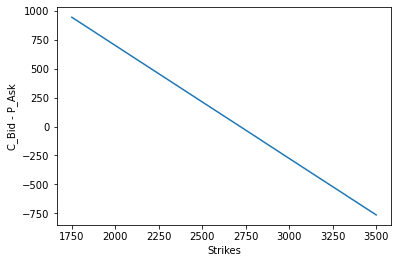

In [6]:

X = df["Strike"]
Y = df["CBid"]-df["PAsk"]

plt.plot(X, Y) 
plt.xlabel('Strikes')
plt.ylabel('C_Bid - P_Ask')
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(np.matrix(X).T, Y)
reg.coef_

array([-0.9769729])

In [8]:
#Calculating r
r = -np.log(-reg.coef_)/t

#Moving on to calculate div yield
df["q"] = (r*t) - np.log((((df["CBid"]-df["PAsk"])*exp(r*t))+df["Strike"])/S0)/t
q = df["q"].mean()

In [9]:
#Estimating Mid prices
df["PMid"] = df[['PBid', 'PAsk']].mean(axis=1)
df["CMid"] = df[['CBid', 'CAsk']].mean(axis=1)

#Moneyness
df["ln(K/S)"] = np.log(df["Strike"]/S0)
moneyness = df["ln(K/S)"]

#Forward Price
F = S0*exp((r-q)*t)
#assining varianbles for further use
C = df["CMid"]
P = df["PMid"]
K = df["Strike"]
F

2726.5418463850324

Now that r and q are figured out, we move on to estimating implied volatility, before that however we need to find out the sensitivity to vol and estimate the vega we do this for dividend paying assets by employing the NEwton method.

In [10]:
#Works

import numpy as np
import scipy.stats as si

def newton_vol_call(S, T, C, K, r, q, sigma):
    output = np.zeros(len(C))
    for num, (c, k) in enumerate(zip(C, K)):

        
        d1 = (np.log(S / k) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / k) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
        fx = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - k * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) - c
    
        vega = (1 / np.sqrt(2 * np.pi)) * S * np.exp(-q * T) * np.sqrt(T) * np.exp((-si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
        tolerance = 0.000001
        x0 = sigma
        xnew  = x0
        xold = x0 - 1
        while abs(xnew - xold) > tolerance:
            xold = xnew
            xnew = (xnew - fx - c) / vega
            
            output[num] = abs(xnew)
        
    return output
    

In [11]:
#Works
def newton_vol_put(S, K, T, P, r, q, sigma):
    output = np.zeros(len(P))
    for num, (p, k) in enumerate(zip(P, K)):
        
        d1 = (np.log(S / k) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / k) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
        fx = k * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) -  p
    
        vega = (1 / np.sqrt(2 * np.pi)) * S * np.exp(-q * T) * np.sqrt(T) * np.exp((-si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
        tolerance = 0.000001
        x0 = sigma
        xnew  = x0
        xold = x0 - 1
        
        while abs(xnew - xold) > tolerance:
            xold = xnew
            xnew = (xnew - fx - p) / vega
        
            output[num] = abs(xnew)
        
    return output

In [12]:
#Calculating implied vols based on estimated values of r and q
df["CVol"] = newton_vol_call(S0, t, C, K, r, q, 0.2)
df["PVol"] = newton_vol_put(S0, K, t, P, r, q, 0.2)

In [13]:
#Various vol aggregation methods

df["MidVol"] = df[['CVol', 'PVol']].mean(axis=1)
df["OTMCs"] = df["CVol"][39:]
df["OTMPs"] = df["PVol"][:39]
df["OTMVol"] = pd.concat([df["PVol"][:39], df["CVol"][39:]])

#Define weights based on moneyness
pw = abs(moneyness[:39])/abs(moneyness.sum())
cw = moneyness[39:]/abs(moneyness.sum())


df["OTMWVol"] = pd.concat([np.multiply(df["PVol"][:39],pw), np.multiply(df["CVol"][39:],cw)])*100

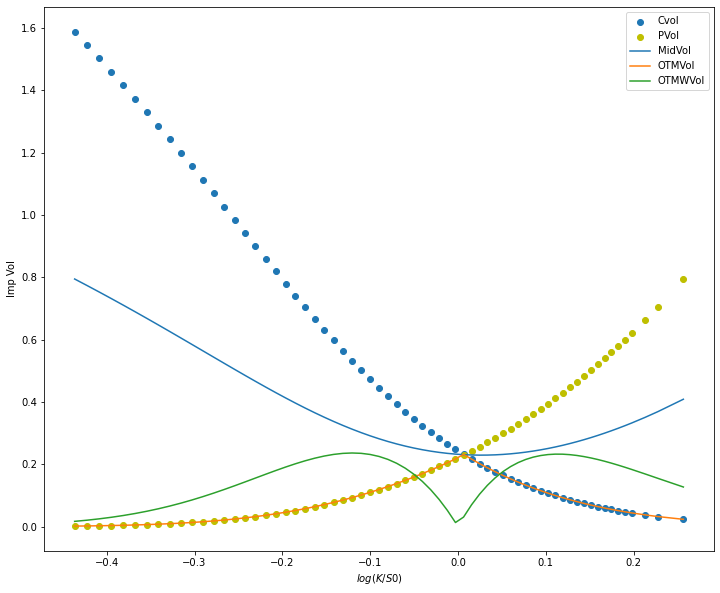

In [14]:
#Lets plot different vols to see if they make sense
CVol = df["CVol"]
PVol = df["PVol"]
MidVol = df["MidVol"]
OTMVol = df["OTMVol"] 
OTMWVol = df["OTMWVol"]
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(moneyness, CVol)
plt.scatter(moneyness, PVol, c='y')

plt.plot(moneyness, MidVol, moneyness, OTMVol,moneyness,OTMWVol)
plt.xlabel('$log (K/S0)$')
plt.ylabel('Imp Vol')
plt.legend(['Cvol', 'PVol', 'MidVol', 'OTMVol','OTMWVol'])
plt.show()

In [15]:

moneyness = df["ln(K/S)"]
M = moneyness
#Choices for Y: Equally Weighted Mid:MidVol , OTM:OTMVol, WOTM:OTMWVol 
#Lets try Mid
y = MidVol**2

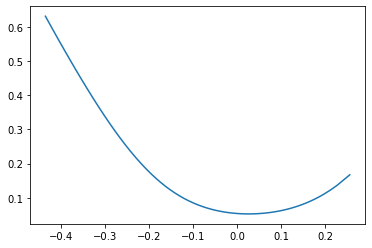

In [16]:
plt.plot(M, y) 
plt.show()

In [17]:
def model(M, coeffs):
    return coeffs[0] + coeffs[1] * (coeffs[2]*(M-coeffs[3]) + np.sqrt((M-coeffs[3])**2 + (coeffs[4])**2 )) 

In [18]:
x0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5], dtype=float)

In [19]:
def residuals(coeffs, y, M):
    return y - model(M, coeffs)

In [20]:
from scipy.optimize import leastsq
x, flag = leastsq(residuals, x0, args=(y, M))

In [21]:
print(x)

[-1.10267428  2.83118383 -0.42959323 -0.1955677  -0.45063433]


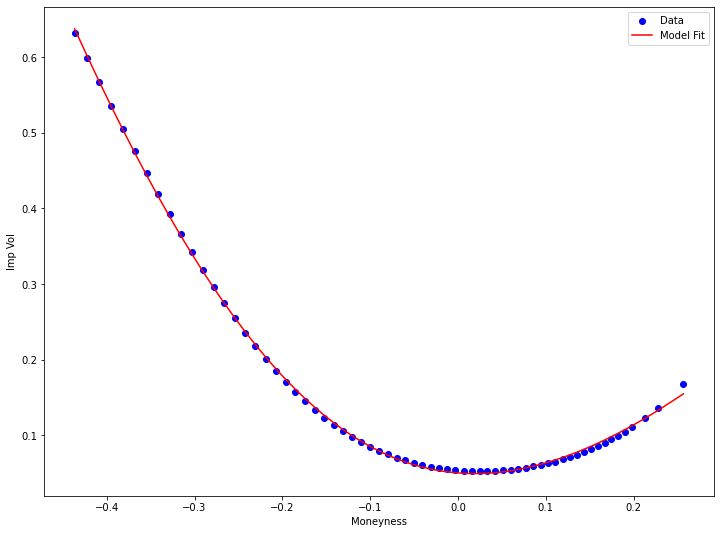

In [22]:
fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(moneyness, y, marker='o', c='b')
plt.plot(moneyness, model(moneyness, x), c='r')
plt.xlabel('Moneyness')
plt.ylabel('Imp Vol')
plt.legend(['Data', 'Model Fit'])
plt.show()

In [23]:
MSE = np.square(np.subtract(y,model(moneyness, x))).mean()
MSE

9.554882814660413e-06

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y,model(moneyness, x))

9.554882814660413e-06

In [25]:
MAD = np.abs(np.subtract(y,model(moneyness, x))).mean()
MAD

0.002577807900629101

In [26]:
def sviCurve (parameters, moneyness):
    a = parameters[0]
    b = parameters[1]
    rho = parameters[2]
    m = parameters[3]
    sigma = parameters[4]
    return [a+b*(rho*(k-m)+np.sqrt((k-m)**2 + sigma**2)) for k in moneyness]

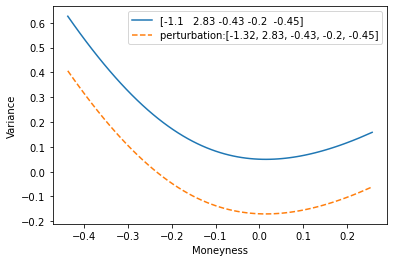

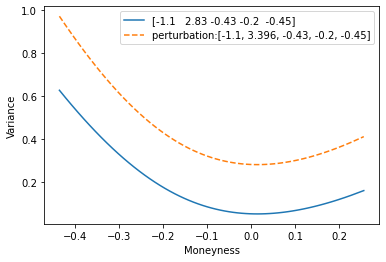

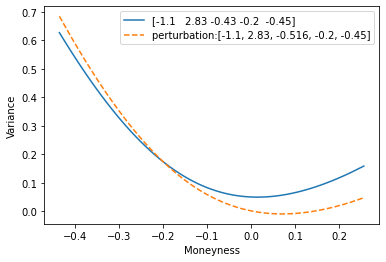

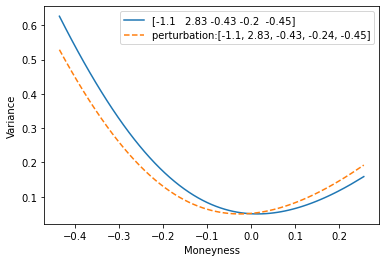

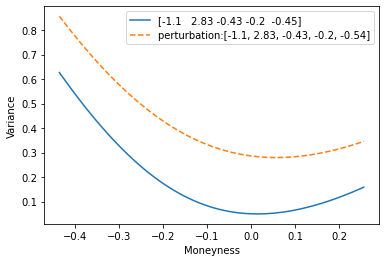

In [27]:
#Looking at sensitivity of each parameter
parameters = np.around(np.array(x), 2)
pert = 1.2 # perturbation of 20%
for i in range(len(parameters)):
    plt.plot(moneyness, sviCurve(parameters, moneyness), label=parameters)
    perturbation = [parameters[p]*pert if p==i else parameters[p] for p in range(len(parameters))]
    plt.plot(moneyness, sviCurve(perturbation, moneyness), linestyle='dashed', label='perturbation:'+str(perturbation))
    plt.xlabel('Moneyness')
    plt.ylabel('Variance')
    plt.legend(loc='best')
    plt.show()

In [28]:
# Lets Fit this back to our model to price a ATM Option:
import numpy as np
def SVI(x, a, b,p,m,s):
    return a+b*(p*(x-m)+sqrt((x-m)**2+s**2))

In [29]:
#If prices are quoted in terms of Vol
var = SVI(np.log(1), x[0], x[1], x[2], x[3], x[4])
vol = np.sqrt(var)
vol

0.2241863162517804

In [83]:
def d1(S,K,T,r,sigma):
    return (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

In [84]:
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma)) 
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma) 

In [85]:
#If prices are quoted in BS
bs_call(S0,S0,t,r,vol)

array([254.55494843])

In [33]:
spread = (df["CBid"][39]-df["CAsk"][39])/2
spread

-0.5499999999999972

Which makes the Call ask price 

In [34]:
bs_call(S0,S0,t,r,vol)[0]- (spread)

255.10494842522968

Bid price:

In [35]:
bs_call(S0,S0,t,r,vol)[0]+ (spread)

254.00494842522966

### Pricing Variance Swap

In [37]:
#Pricing Variance Swap as per GS paper
#0. Obtain SVI derived OP's
#1. Define your OTM option set 
#2. determine delta K's
#3. first and last being special cases
#4. determine ATM strike and index
#5. calculate the frwd term
#6. Sum over the contributions 



In [38]:
df['SVI_Vol'] = sviCurve(parameters, moneyness)
# modifying the BS to take in vectors of K's and Volatility SVI's
def bs_call(S,K,T,r,sigma):
    output = np.zeros(len(P))
    for num, (s, k) in enumerate(zip(df.SVI_Vol, K)):
        output[num] = S*norm.cdf(d1(S,k,T,r,s))-k*exp(-r*T)*norm.cdf(d2(S,k,T,r,s))
        
    return output

def bs_put(S,K,T,r,sigma):
    output = np.zeros(len(P))
    for num, (s, k) in enumerate(zip(df.SVI_Vol, K)):
        output[num] = k*exp(-r*T)-S+(S*norm.cdf(d1(S,k,T,r,s))-k*exp(-r*T)*norm.cdf(d2(S,k,T,r,s)))
        
    return output

df['SVIC'] = bs_call(S0,K,t,r,df.SVI_Vol)
df['SVIP'] = bs_put(S0,K,t,r,df.SVI_Vol)

In [126]:
## Revision using SVI derived prices
df['Put_Minus_Call'] = np.abs(df.SVIP - df.SVIC)

# differences between the different strikes of the series
df['del_K'] = None
df['del_K'].iloc[1:-1] = [(df['Strike'].iloc[i + 1] - df['Strike'].iloc[i - 1]) / 2 for i in df.index[1:-1]]
df['del_K'].iloc[0] = df['Strike'].iloc[1] - df['Strike'].iloc[0]

df['del_K'].loc[df.index[-1:]] = float(df['Strike'].iloc[-1:]) \
            - float(df['Strike'].iloc[-2:-1])

#Find the smallest diff
min_index = df.Put_Minus_Call.argmin()

# the forward price of that option
forward_price = df['Strike'].iloc[min_index] \
                    + r * df.Put_Minus_Call[min_index]

K_0 = df['Strike'][forward_price - df['Strike'] > 0].max()

# the index of the ATM strike
K_0_index = df.index[df['Strike'] == K_0][0]



# selects the OTM options range
df['M'] = pd.concat((df.SVIP[0:K_0_index],
                           df.SVIC[K_0_index:]))

# ATM we take the average of put and call price
df['M'].iloc[K_0_index] = (df['SVIC'][K_0_index]
                            + df['SVIP'][K_0_index]) / 2

# the single OTM values
df['MFactor'] = (r * (df['del_K'] * df['M'])
                         / (df['Strike']) ** 2)

# the forward term
fterm = 1. / t * (forward_price / K_0 - 1) ** 2
# adding up
sigma = 2 / t * np.sum(df.MFactor) - fterm
v = 100 * sqrt(sigma)

In [127]:
sigma

array([0.00069648])